In [23]:
path_to_directory = "C:/Users/Utilizador/OneDrive/Documentos/DS"
file_tag = "class_ny_arrests"

train_filename = f"{path_to_directory}/datasets/{file_tag}_train_redundant.csv"
test_filename = f"{path_to_directory}/datasets/{file_tag}_test_redundant.csv"

In [24]:
from numpy import array, ndarray
from pandas import read_csv, DataFrame

file_tag = "set2_modeling"
#index_col = "ARREST_KEY"    #acho que dropamos dps tira se for preciso
target = "JURISDICTION_CODE"    #corrigir nome
data_train: DataFrame = read_csv(train_filename)
data_test: DataFrame = read_csv(test_filename)

labels: list = list(data_train[target].unique())
labels.sort()
print(f"Labels={labels}")
print(data_train.shape)
print(data_test.shape)

positive: int = 1
negative: int = 0
values: dict[str, list[int]] = {
    "Original": [
        len(data_train[data_train[target] == negative])+len(data_test[data_test[target] == negative]),
        len(data_train[data_train[target] == positive])+len(data_test[data_test[target] == positive]),
    ]
}

y_trn: array = data_train.pop(target).to_list()
X_trn: ndarray = data_train.values

y_tst: array = data_test.pop(target).to_list()
X_tst: ndarray = data_test.values



Labels=[0, 1]
(80000, 15)
(20000, 15)


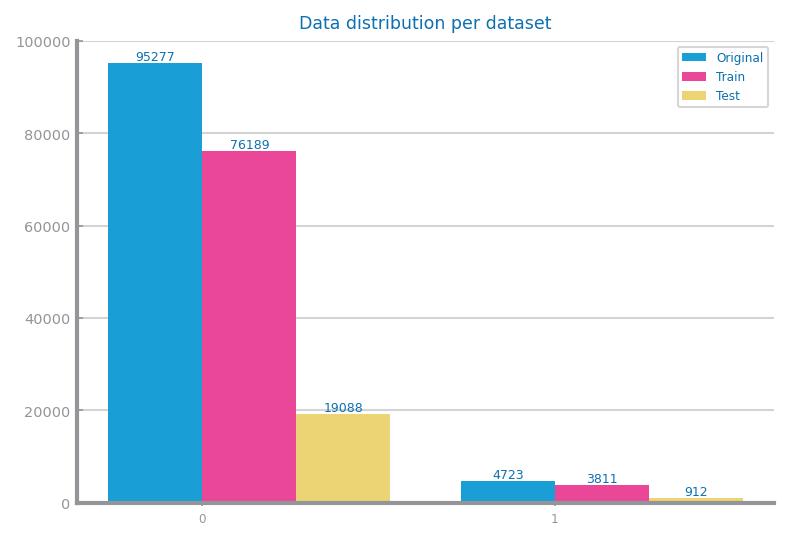

In [25]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart


#trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
trnX = X_trn
trnY = y_trn
tstX = X_tst
tstY = y_tst

train: DataFrame = concat(
    [DataFrame(trnX, columns=data_train.columns), DataFrame(trnY, columns=[target])], axis=1
)
train.to_csv(f"datasets/{file_tag}_train.csv", index=False)

test: DataFrame = concat(
    [DataFrame(tstX, columns=data_test.columns), DataFrame(tstY, columns=[target])], axis=1
)
test.to_csv(f"datasets/{file_tag}_test.csv", index=False)

values["Train"] = [
    len(train[train[target] == negative]),
    len(train[train[target] == positive]),
]
values["Test"] = [
    len(test[test[target] == negative]),
    len(test[test[target] == positive]),
]

figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

In [26]:
from pandas import read_csv


def read_train_test_from_files(
    train_fn: str, test_fn: str, target: str = "class"
) -> tuple[ndarray, ndarray, array, array, list, list]:
    train: DataFrame = read_csv(train_fn, index_col=None)
    labels: list = list(train[target].unique())
    labels.sort()
    trnY: array = train.pop(target).to_list()
    trnX: ndarray = train.values

    test: DataFrame = read_csv(test_fn, index_col=None)
    tstY: array = test.pop(target).to_list()
    tstX: ndarray = test.values
    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()


train_filename = f"datasets/{file_tag}_train.csv"
test_filename = f"datasets/{file_tag}_test.csv"
eval_metric = "accuracy"

trnX: ndarray
tstX: ndarray
trnY: array
tstY: array
labels: list
vars: list
trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=80000 Test#=20000
Labels=[0, 1]


In [27]:
from dslabs_functions import read_train_test_from_files


trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target)

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=80000 Test#=20000
Labels=[0, 1]


In [28]:
data123: DataFrame = read_csv(train_filename)
data123.head()

,PD_CD,KY_CD,OFNS_DESC,ARREST_BORO,ARREST_PRECINCT,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Year,Day,Month_sin,Month_cos,JURISDICTION_CODE
0,66.0,19.0,11.0,3.0,81.0,3.0,0.0,1.0,1005312.0,190540.0,2019.0,14.0,1.000,0.0,0
1,79.0,35.0,60.0,3.0,78.0,4.0,1.0,1.0,991360.0,187427.0,2019.0,4.0,1.000,0.0,0
2,9.0,37.0,6.0,4.0,44.0,3.0,0.0,1.0,1006537.0,244511.0,2019.0,2.0,1.000,0.0,0
3,66.0,19.0,11.0,3.0,77.0,3.0,0.0,1.0,999564.0,183868.0,2019.0,23.0,0.866,0.5,0
4,271.0,40.0,34.0,5.0,123.0,4.0,0.0,4.0,918975.0,130338.0,2019.0,20.0,0.866,-0.5,0


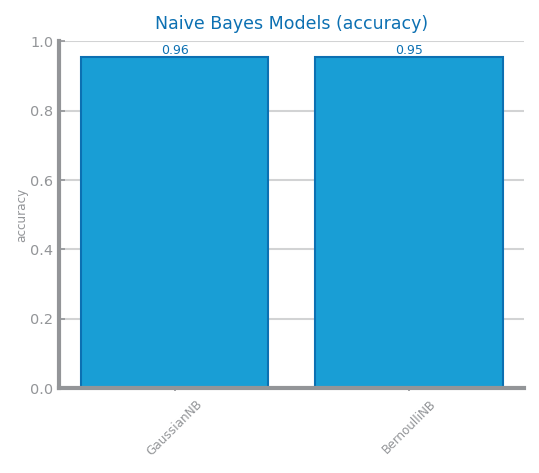

In [29]:
from numpy import array, ndarray
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_bar_chart


def naive_Bayes_study(
    trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, metric: str = "accuracy"
) -> tuple:
    estimators: dict = {
        "GaussianNB": GaussianNB(),
        "BernoulliNB": BernoulliNB(),
    }

    xvalues: list = []
    yvalues: list = []
    best_model = None
    best_params: dict = {"name": "", "metric": metric, "params": ()}
    best_performance = 0
    for clf in estimators:
        xvalues.append(clf)
        estimators[clf].fit(trnX, trnY)
        prdY: array = estimators[clf].predict(tstX)
        eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if eval - best_performance > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["name"] = clf
            best_params[metric] = eval
            best_model = estimators[clf]
        yvalues.append(eval)
        # print(f'NB {clf}')
    plot_bar_chart(
        xvalues,
        yvalues,
        title=f"Naive Bayes Models ({metric})",
        ylabel=metric,
        percentage=True,
    )

    return best_model, best_params


figure()
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, eval_metric)
savefig(f"images/{file_tag}_nb_{eval_metric}_study.png")
show()

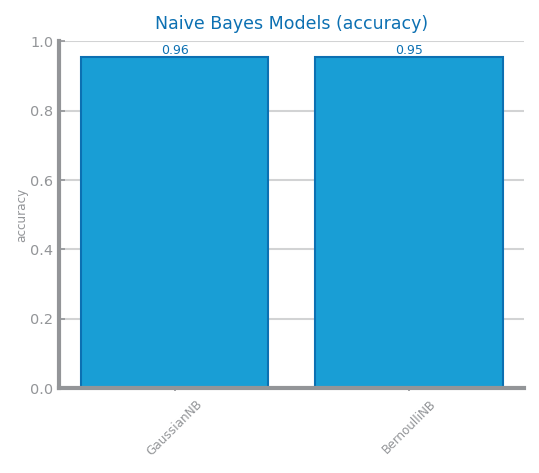

In [30]:
figure()
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, "accuracy")
savefig(f"images/{file_tag}_nb_recall_study.png")
show()

<Figure size 600x450 with 0 Axes>

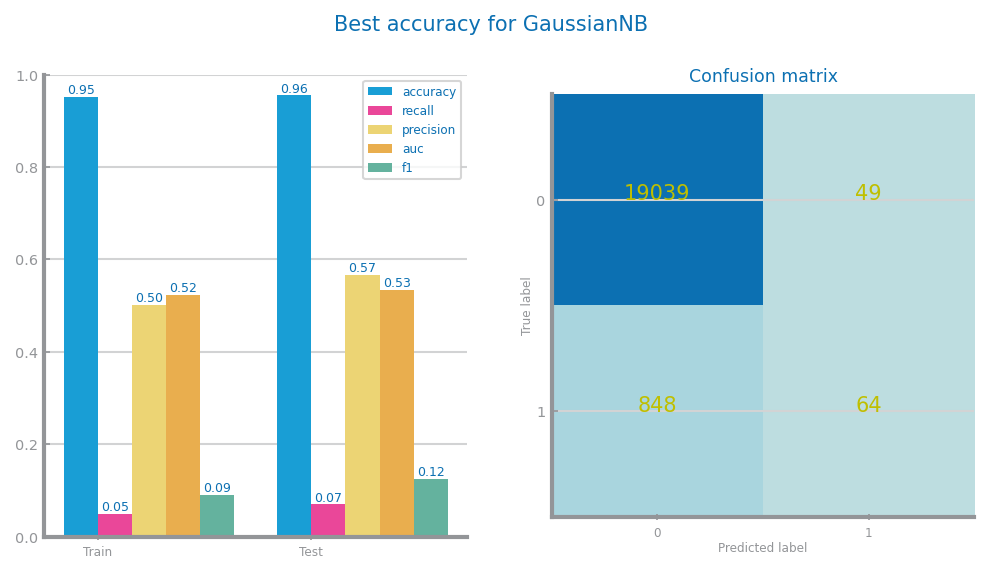

In [31]:
from dslabs_functions import plot_evaluation_results

prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_{params["name"]}_best_{params["metric"]}_eval.png')
show()

KNN

Train#=80000 Test#=20000
Labels=[0, 1]
KNN best with k=1 and manhattan


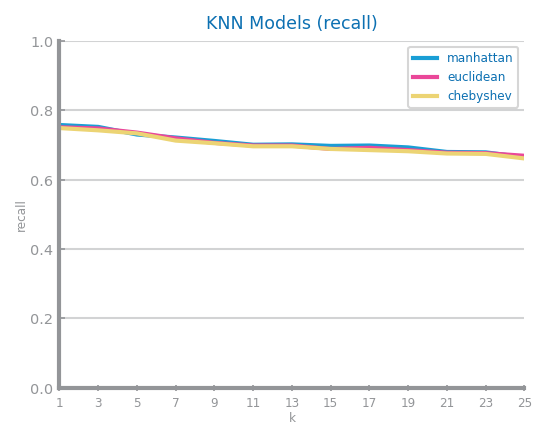

In [32]:
from typing import Literal
from numpy import array, ndarray
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_multiline_chart
from dslabs_functions import read_train_test_from_files, plot_evaluation_results

def knn_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, k_max: int=19, lag: int=2, metric='accuracy'
        ) -> tuple[KNeighborsClassifier | None, dict]:
    dist: list[Literal['manhattan', 'euclidean', 'chebyshev']] = ['manhattan', 'euclidean', 'chebyshev']

    kvalues: list[int] = [i for i in range(1, k_max+1, lag)]
    best_model: KNeighborsClassifier | None = None
    best_params: dict = {'name': 'KNN', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict[str, list] = {}
    for d in dist:
        y_tst_values: list = []
        for k in kvalues:
            clf = KNeighborsClassifier(n_neighbors=k, metric=d)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance: float = eval
                best_params['params'] = (k, d)
                best_model = clf
            # print(f'KNN {d} k={k}')
        values[d] = y_tst_values
    print(f'KNN best with k={best_params['params'][0]} and {best_params['params'][1]}')
    plot_multiline_chart(kvalues, values, title=f'KNN Models ({metric})', xlabel='k', ylabel=metric, percentage=True)

    return best_model, best_params

train_filename = f"datasets/{file_tag}_train.csv"
test_filename = f"datasets/{file_tag}_test.csv"
eval_metric = 'recall'

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train_filename, test_filename, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

figure()
best_model, params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric=eval_metric)
savefig(f'images/{file_tag}_knn_{eval_metric}_study.png')
show()

<Figure size 600x450 with 0 Axes>

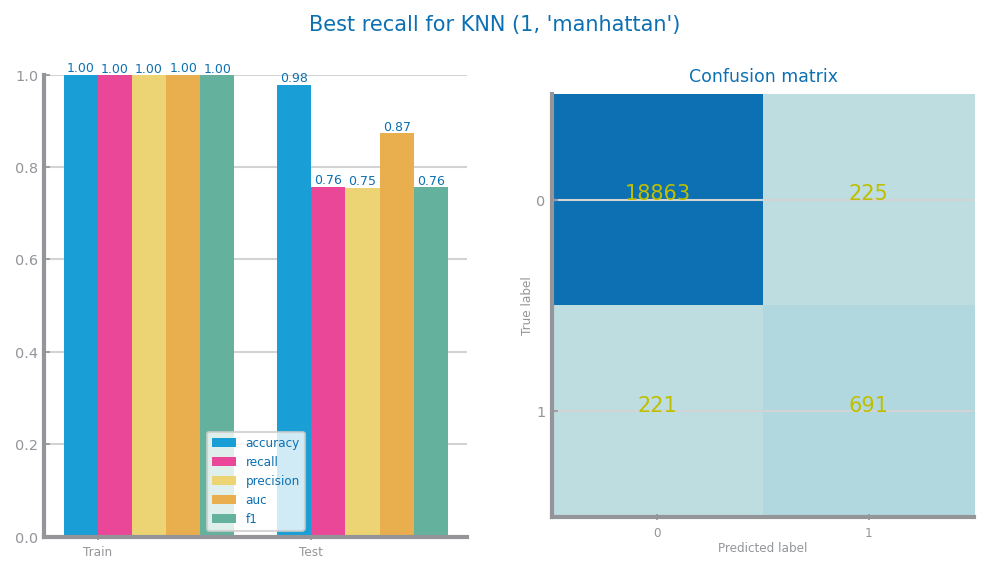

In [33]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_knn_{params["name"]}_best_{params["metric"]}_eval.png')
show()

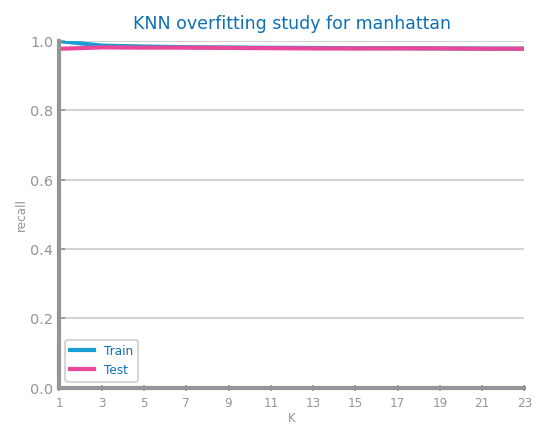

In [34]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = params["params"][1]
K_MAX = 25
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
acc_metric: str = "accuracy"
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"KNN overfitting study for {distance}",
    xlabel="K",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_knn_overfitting.png")
show()

Decision trees

Train#=80000 Test#=20000
Labels=[0, 1]
DT best with entropy and d=14


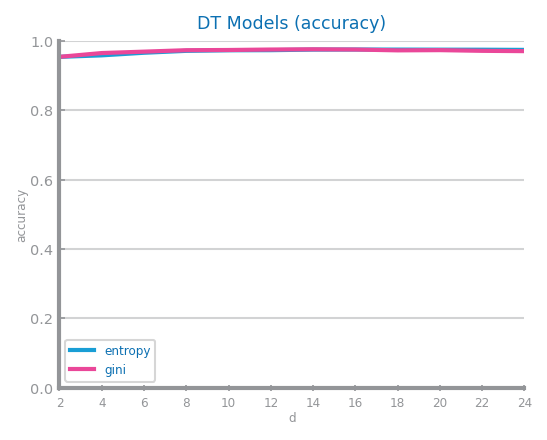

In [35]:
from typing import Literal
from numpy import array, ndarray
from matplotlib.pyplot import figure, savefig, show
from sklearn.tree import DecisionTreeClassifier
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, read_train_test_from_files
from dslabs_functions import plot_evaluation_results, plot_multiline_chart


def trees_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, d_max: int=10, lag:int=2, metric='accuracy'
        ) -> tuple:
    criteria: list[Literal['entropy', 'gini']] = ['entropy', 'gini']
    depths: list[int] = [i for i in range(2, d_max+1, lag)]

    best_model: DecisionTreeClassifier | None = None
    best_params: dict = {'name': 'DT', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict = {}
    for c in criteria:
        y_tst_values: list[float] = []
        for d in depths:
            clf = DecisionTreeClassifier(max_depth=d, criterion=c, min_impurity_decrease=0)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance = eval
                best_params['params'] = (c, d)
                best_model = clf
            # print(f'DT {c} and d={d}')
        values[c] = y_tst_values
    print(f'DT best with {best_params['params'][0]} and d={best_params['params'][1]}')
    plot_multiline_chart(depths, values, title=f'DT Models ({metric})', xlabel='d', ylabel=metric, percentage=True)

    return best_model, best_params

eval_metric = 'accuracy'

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train_filename, test_filename, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

figure()
best_model, params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric=eval_metric)
savefig(f'images/{file_tag}_dt_{eval_metric}_study.png')
show()

<Figure size 600x450 with 0 Axes>

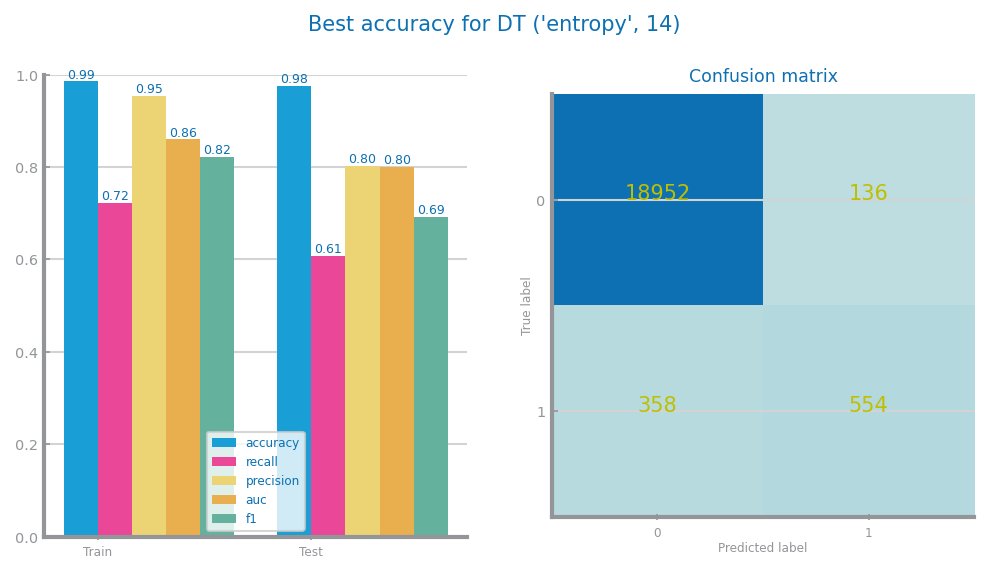

In [36]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_dt_{params["name"]}_best_{params["metric"]}_eval.png')
show()

In [37]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis
from subprocess import call

tree_filename: str = f"images/{file_tag}_dt_{eval_metric}_best_tree"
max_depth2show = 3
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(14, 6))
imshow(imread(tree_filename + ".png"))
axis("off")
show()

FileNotFoundError: [WinError 2] O sistema não conseguiu localizar o ficheiro especificado